11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/10
938/938 [==============================] - 14s 4ms/step - loss: -2.7531 - accuracy: 0.1046
Epoch 2/10
938/938 [==============================] - 5s 5ms/step - loss: -2.7531 - accuracy: 0.1011
Epoch 3/10
938/938 [==============================] - 4s 4ms/step - loss: -2.7531 - accuracy: 0.1010
Epoch 4/10
938/938 [==============================] - 4s 4ms/step - loss: -2.7531 - accuracy: 0.1001
Epoch 5/10
938/938 [==============================] - 5s 5ms/step - loss: -2.7531 - accuracy: 0.1023
Epoch 6/10
938/938 [==============================] - 4s 4ms/step - loss: -2.7531 - accuracy: 0.1010
Epoch 7/10
938/938 [==============================] - 4s 4ms/step - loss: -2.7531 - accuracy: 0.0999
Epoch 8/10
938/938 [==============================] - 5s 5ms/step - loss: -2.7531 - accuracy: 0.1005
Epoch 9/10
938/938 [==============================] - 4s 5ms/step - loss: -2.7531 - accuracy: 0.1004
Epoch 10/10
313/313 [====

<ipython-input-1-2b5f0c34f612>:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap=plt.cm.get_cmap("jet", 10))


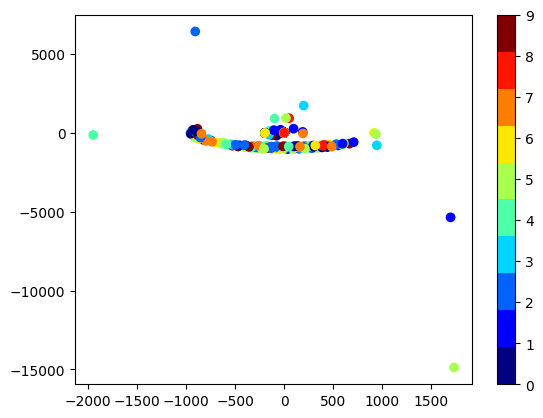

Epoch 1/10
844/844 [==============================] - 4s 3ms/step - loss: 2.3014 - accuracy: 0.1122 - val_loss: 2.3021 - val_accuracy: 0.1050
Epoch 2/10
844/844 [==============================] - 3s 3ms/step - loss: 2.3013 - accuracy: 0.1132 - val_loss: 2.3020 - val_accuracy: 0.1050
Epoch 3/10
844/844 [==============================] - 3s 4ms/step - loss: 2.3013 - accuracy: 0.1132 - val_loss: 2.3018 - val_accuracy: 0.1050
Epoch 4/10
844/844 [==============================] - 3s 4ms/step - loss: 2.3013 - accuracy: 0.1132 - val_loss: 2.3019 - val_accuracy: 0.1050
Epoch 5/10
844/844 [==============================] - 3s 3ms/step - loss: 2.3013 - accuracy: 0.1132 - val_loss: 2.3020 - val_accuracy: 0.1050
Epoch 6/10
844/844 [==============================] - 3s 3ms/step - loss: 2.3013 - accuracy: 0.1132 - val_loss: 2.3020 - val_accuracy: 0.1050
Epoch 7/10
844/844 [==============================] - 3s 3ms/step - loss: 2.3013 - accuracy: 0.1132 - val_loss: 2.3021 - val_accuracy: 0.1050
Epoch 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# 1. Create a Keras model
def create_model():
    inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    return model

model = create_model()

# 2. Custom DataGenerator
class DataGenerator(keras.utils.Sequence):
    def __init__(self, images, labels, batch_size=64):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.indices = np.arange(len(self.images))

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indices = self.indices[start:end]
        x_batch = self.images[batch_indices]
        y_batch = self.labels[batch_indices].astype('float32')  # Convert labels to float32
        return x_batch[..., np.newaxis], y_batch

train_data_generator = DataGenerator(x_train, y_train)

# 3. Custom contrastive loss function
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = keras.backend.square(y_pred)
    margin_square = keras.backend.square(keras.backend.maximum(margin - y_pred, 0))
    return keras.backend.mean(y_true * square_pred + (1 - y_true) * margin_square)

# 4. Pretrain the model and visualize with t-SNE
def visualize_tsne(features, labels):
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(features)
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap=plt.cm.get_cmap("jet", 10))
    plt.colorbar(ticks=range(10))
    plt.show()

# Pretrain the model
model.compile(optimizer='adam', loss=contrastive_loss, metrics=['accuracy'])
model.fit(train_data_generator, epochs=10, verbose=1)

# Extract features
feature_model = keras.Model(model.input, model.layers[-2].output)
features_train = feature_model.predict(x_train[..., np.newaxis])
features_test = feature_model.predict(x_test[..., np.newaxis])

# Visualize t-SNE
visualize_tsne(features_train, y_train)

# 5. Train MLP and report accuracy
mlp = keras.Sequential([
    layers.Input(shape=(128,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Train the MLP
mlp.fit(features_train, y_train, batch_size=64, epochs=10, validation_split=0.1, verbose=1)

#Evaluate the MLP
_, test_accuracy = mlp.evaluate(features_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")
